# Hakea dataset  notebook

The data was downloaded from [here](https://zenodo.org/records/3976850#.ZGW8ERlBzmE).

Katherine James and Karen Bradshaw. [*Detecting plant species in the field with deep learning and drone technology*](https://doi.org/10.1111/2041-210X.13473). **Methods in Ecology and Evolution, 11(11)**. (2020)

## Class description:
- **Label: 0** (Background)
- **Label: 1** (Hakea)

## Channel description:

- **Channel: 1** (Red - R)
- **Channel: 2** (Green - G)
- **Channel: 3** (Blue - B)

In [1]:
import os
import time
import warnings
from time import strftime
from functools import partial

from PIL import Image
import tifffile as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import numpy as np
from skimage import io as skio
from scipy.special import expit, softmax

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as func

from datasets import ImagesDataset, BalancedImagesDataset
from models import FCN_ResNet50, FCN_ResNet101, LRASPP_MobileNet
from models import DeeplabV3_MobileNet, DeeplabV3_ResNet50, Unet2D
from utils import color_codes, time_to_string, normalise

The imports can be divided into a few different groups:
- **General packages**: This group include basic python libraries (included with any distribution of python) to perform basic operations relations to files, measuring execution time or function utilities.
- **Image packages**: This dataset uses a specific type of GeoTIFF files (?). To open them we will be using image libraries focused on TIFF files.
- **Plotting tools**: matplotlib (and seaborn) is the most commonly useful visualisation tool for plotting results.
- **Scientific tools**: This larger group includes numpy (equivalent to matlab array processing), scipy (numpy extension for scientific projects), sklearn (and its image analysis extension) and opencv (for image tools). These packages provide tools to manipulate data.
- **Autodifferentiable packages**: For this notebook we will be using pytorch as our tool to build and train deep learning models.
- **Tools from the repository**: To simplify our networks, some of the meaty code is stored on a relevant file including dataset implementations, models based on torchvision and other utils.

# Data preparation
This is a structured dataset that does not rely on mosaics. Instead, the original (RGB) raw images are provided in JPEG format. Masks for the images are also provided on that format. Furthermore, this is a binary classification problem, the majority of patches contain the species of interest (hakea) and one specimen might appear in more than one image. There does not seem to be any apparent data leakage after visual inspection.

Due to the simplicity of the dataset, only the paths and filenames are defined on the following cell. We will also show some random training and testing examples with the overlayed mask. In that sense, the cell can be run multiple times to see different examples.

In [2]:
d_path = '/home/mariano/data/Wetlands/Hakea/'
train_path = os.path.join(d_path, 'train')
train_annot_path = os.path.join(train_path, 'masks')
test_path = os.path.join(d_path, 'test')
test_annot_path = os.path.join(test_path, 'masks')


# Loading training images and masks
training_ids = [
    f.split('.')[0]
    for f in os.listdir(train_path)
    if f.endswith('.jpg')
]
training_images = [
    skio.imread(
        os.path.join(train_path, '{:}.jpg'.format(im_id))
    )
    for im_id in training_ids
]
training_masks = [
    np.mean(
        skio.imread(
            os.path.join(train_annot_path, '{:}.jpg'.format(im_id))
        ), axis=-1
    ) > 0
    for im_id in training_ids
]

# Loading testing images and masks

testing_ids = [
    f.split('.')[0]
    for f in os.listdir(test_path)
    if f.endswith('.jpg')
]
testing_images = [
    skio.imread(
        os.path.join(test_path, '{:}.jpg'.format(im_id))
    )
    for im_id in testing_ids
]
testing_masks = [
    np.mean(
        skio.imread(
            os.path.join(test_annot_path, '{:}.jpg'.format(im_id))
        ), axis=-1
    ) > 0
    for im_id in testing_ids
]

Text(0.5, 1.0, 'Testing image 27')

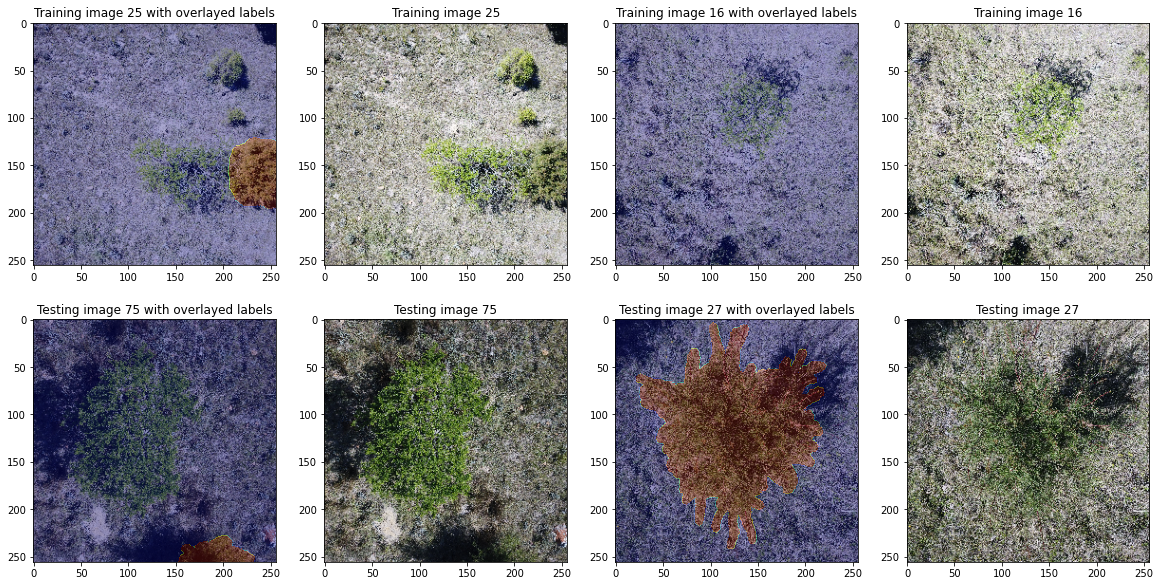

In [3]:
patch_size = 256

r_training_ids = np.random.permutation(len(training_ids))
plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
idx_0 = r_training_ids[0]
plt.imshow(
    cv2.resize(
        training_images[idx_0], dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_LINEAR
    )
)
plt.imshow(
    cv2.resize(
        training_masks[idx_0].astype(np.uint8), dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_NEAREST
    ),
    alpha=0.33, cmap='jet'
)
plt.title('Training image {:} with overlayed labels'.format(training_ids[idx_0]))

plt.subplot(2, 4, 2)
plt.imshow(
    cv2.resize(
        training_images[idx_0], dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_LINEAR
    )
)
plt.title('Training image {:}'.format(training_ids[idx_0]))

idx_1 = r_training_ids[1]
plt.subplot(2, 4, 3)
plt.imshow(
    cv2.resize(
        training_images[idx_1], dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_LINEAR
    )
)
plt.imshow(
    cv2.resize(
        training_masks[idx_1].astype(np.uint8), dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_NEAREST
    ),
    alpha=0.33, cmap='jet'
)
plt.title('Training image {:} with overlayed labels'.format(training_ids[idx_1]))

plt.subplot(2, 4, 4)
plt.imshow(
    cv2.resize(
        training_images[idx_1], dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_LINEAR
    )
)
plt.title('Training image {:}'.format(training_ids[idx_1]))

r_testing_ids = np.random.permutation(len(testing_ids))
plt.subplot(2, 4, 5)
idx_0 = r_testing_ids[0]
plt.imshow(
    cv2.resize(
        testing_images[idx_0], dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_LINEAR
    )
)
plt.imshow(
    cv2.resize(
        testing_masks[idx_0].astype(np.uint8), dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_NEAREST
    ),
    alpha=0.33, cmap='jet'
)
plt.title('Testing image {:} with overlayed labels'.format(testing_ids[idx_0]))

plt.subplot(2, 4, 6)
plt.imshow(
    cv2.resize(
        testing_images[idx_0], dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_LINEAR
    )
)
plt.title('Testing image {:}'.format(testing_ids[idx_0]))

idx_1 = r_testing_ids[1]
plt.subplot(2, 4, 7)
plt.imshow(
    cv2.resize(
        testing_images[idx_1], dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_LINEAR
    )
)
plt.imshow(
    cv2.resize(
        testing_masks[idx_1].astype(np.uint8), dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_NEAREST
    ),
    alpha=0.33, cmap='jet'
)
plt.title('Testing image {:} with overlayed labels'.format(testing_ids[idx_1]))

plt.subplot(2, 4, 8)
plt.imshow(
    cv2.resize(
        testing_images[idx_1], dsize=(patch_size, patch_size),
        interpolation=cv2.INTER_LINEAR
    )
)
plt.title('Testing image {:}'.format(testing_ids[idx_1]))

# Main function
The following cell contains the main function that will be used to run all the experiments for the dataset.

```python
def run_segmentation_experiments(
    master_seed, network_name, display_name, experiment_name, network_f, training_data, testing_data,
    weight_path, maps_path, classes=None, patch_size=256, overlap=128, epochs=10, patience=5,
    n_seeds=30, n_inputs=3, n_classes=2, train_batch=20, test_batch=50, saliency_batch=4, verbose=1
)
```

This is the main function involved in the experimentation process. To allow for multiple *random* runs, the function requires a **master_seed** (that defines the seed that will used to determine the seeds for each random run). Furthermore, a **network_name** is required for the weights file while a **display_name** is required to display debugging messages regarding the required *function* to instantiate the **network** that will be trained. The **classes** variable with a list of the class names and the **experiment_name** variables are also used to display messages regarding the results and experiment type.

For training and testing, a tuple of lists containing the images and masks are required as **training_data** and **testing_data** for training and testing, respectively; and the **weight_path** and **maps_path** where the model weights and salienc maps will be stored. The other parameters relate to the network hyperparameters and training / optimisation parameters and are optional.

In [4]:
def run_segmentation_experiments(
    master_seed, network_name, display_name, experiment_name, network_f, training_data, testing_data,
    weight_path, maps_path, classes=None, patch_size=256, overlap=128, epochs=10, patience=5,
    n_seeds=30, n_inputs=3, n_classes=2, train_batch=20, test_batch=50, saliency_batch=4, verbose=1
):
    # Init
    training_images, training_masks = training_data
    testing_images, testing_masks = testing_data
    
    # While we use a BalancedLythrumDataset for training, it might
    # be a good idea to also use LythrumDataset. The choice of dataset
    # should be coherent with what we do on the other datasets.  
    training_set = ImagesDataset(
        training_images, training_masks
    )
    validation_set = ImagesDataset(
        training_images, training_masks
    )
    
    # Choosing random runs.
    np.random.seed(master_seed)
    seeds = np.random.randint(0, 100000, n_seeds)
    c = color_codes()

    dsc_list = []
    class_dsc_list = []
    # Main loop to run each independent random experiment.
    for test_n, seed in enumerate(seeds):
        acc = 0
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # The network will only be instantiated with the number of output classes
        # (2 in this notebok). Therefore, networks that need extra parameters (like ViT)
        # will need to be passed as a partial function.
        net = network_f(n_inputs=n_inputs, n_outputs=n_classes)
               
        # This is a leftover from legacy code. If init is set to True (the default option),
        # a first validation epoch will be run to determine the loss before training.
        net.init = False
        
        # The number of parameters is only captured for debugging and printing.
        n_param = sum(
            p.numel() for p in net.parameters() if p.requires_grad
        )

        if verbose > 1:
            print(
                '{:}[{:}] {:}Starting experiment {:}(seed {:05d} - {:} {:}[{:,} parameters]{:})'
                '{:} [{:02d}/{:02d}] {:}for {:} segmentation{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['b'] + display_name,
                    c['nc'], n_param, c['y'],
                    c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], c['nc']
                )
            )
        
        training_loader = DataLoader(
            training_set, train_batch, True
        )
        validation_loader = DataLoader(
            validation_set, test_batch
        )
        model_path = os.path.join(
            weight_path, '{:}-balanced_s{:05d}_p{:03d}.pt'.format(network_name, seed, patch_size)
        )
        
        # For efficiency, we only run the code once. If the weights are
        # stored on disk, we do not need to train again.
        try:
            net.load_model(model_path)
        except IOError:
            net.train()
            print(''.join([' '] * 200), end='\r')
            net.fit(training_loader, validation_loader, epochs=epochs, patience=patience)
            net.save_model(model_path)
        
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}Testing {:}(seed {:05d}){:} [{:02d}/{:02d}] '
                '{:}for {:} segmentation <{:03d} samples>{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], 
                    len(training_set), c['nc']
                )
            )
        
        # Metric evaluation.
        net.eval()
        with torch.no_grad():
            image_dsc = []
            image_class_dsc = []
            # Intermediate buffers for class metrics.
            for i, (input_image, mask_i) in enumerate(zip(testing_images, testing_masks)):
                norm_image = normalise(input_image)
                pred_map = net.inference(
                    np.expand_dims(norm_image, axis=0).astype(np.float32)
                )[0]
            
                pred_y = np.argmax(pred_map, axis=0).astype(np.uint8)
                y = mask_i.astype(np.uint8)
                intersection = np.stack([
                    2 * np.sum(np.logical_and(pred_y == lab, y == lab))
                    for lab in range(n_classes)
                ])
                card_pred_y = np.stack([
                    np.sum(pred_y == lab) for lab in range(n_classes)
                ])
                card_y = np.stack([
                    np.sum(y == lab) for lab in range(n_classes)
                ])
                dsc_k = intersection / (card_pred_y + card_y)
                dsc = np.nanmean(dsc_k)
                image_dsc.append(dsc)
                image_class_dsc.append(dsc_k.tolist())

                for j, map_j in enumerate(softmax(pred_map, axis=0)):
                    map_path = os.path.join(
                        maps_path, '{:}-balanced_s{:05d}_map{:02d}_k{:02d}.png'.format(
                            network_name, seed, i, j
                        )
                    )
                    final_map = (255 * map_j).astype(np.uint8)
                    skio.imsave(map_path, final_map.astype(np.uint8))
                map_path = os.path.join(
                    maps_path, '{:}-balanced_s{:05d}_masks{:02d}.png'.format(
                        network_name, seed, i
                    )
                )
                final_map = (255 * (pred_y / (n_classes - 1))).astype(np.uint8)
                skio.imsave(map_path, final_map.astype(np.uint8))
                
                dsc = np.nanmean(image_dsc, axis=0)
                class_dsc = np.nanmean(image_class_dsc, axis=0)
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'
                '{:5.3f}{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'], dsc, c['nc']
                )
            )

            class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
                for k, dsc_k in zip(classes, class_dsc)
            ])
            print(
                '{:}[{:}] {:}Class DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'] + class_dsc_s + c['nc']
                )
            )
        elif verbose > 1:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                )
            )
        elif verbose > 0:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                ), end='\r'
            )
        net = None
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        dsc_list.append(image_dsc)
        class_dsc_list.append(image_class_dsc)
    
    # Metrics for all the runs.
    if verbose > 0:
        print(''.join([' '] * 200), end='\r')
        print(
            '{:}[{:}] {:} Mean DSC{:} {:5.3f}{:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"),
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'], np.nanmean(dsc_list), c['nc']
            )
        )
        class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
            for k, dsc_k in zip(
                classes, np.nanmean(class_dsc_list, axis=(0, 1))
            )
        ])
        print(
            '{:}[{:}] {:} Mean class DSC {:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), 
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'] + class_dsc_s + c['nc']
            )
        )
        
    return dsc_list, class_dsc_list

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

master_seed = 42
train_batch = 8
test_batch = 16
epochs = 50
patience = 50
name = 'hakea'
classes = [
    'Background', 'Hakea'
]

training_resized = []
training_mask_resized = []
for i, (train_i, mask_i) in enumerate(zip(training_images, training_masks)):
    if np.any(mask_i):
        mosaic_rgb = cv2.resize(
            train_i, dsize=(patch_size, patch_size),
            interpolation=cv2.INTER_LINEAR
        )
        training_resized.append(np.moveaxis(mosaic_rgb, -1, 0))
        mask = cv2.resize(
            mask_i.astype(np.uint8), dsize=(patch_size, patch_size),
            interpolation=cv2.INTER_NEAREST
        )
        training_mask_resized.append(mask)

# The experiments are run next. We capture some warnings related to
# image loading to clean the debugging console.
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    testing_resized = []
    testing_mask_resized = []
    for i, (test_i, mask_i) in enumerate(zip(testing_images, testing_masks)):
        image_path = os.path.join(
            d_path, 'Predictions', 'testing_image{:02d}.png'.format(i)
        )
        mosaic_rgb = cv2.resize(
            test_i, dsize=(patch_size, patch_size),
            interpolation=cv2.INTER_LINEAR
        )
        testing_resized.append(np.moveaxis(mosaic_rgb, -1, 0))
        skio.imsave(
            image_path, 
            (255 * (mosaic_rgb / np.max(mosaic_rgb))).astype(np.uint8)
        )
        mask = cv2.resize(
            mask_i.astype(np.uint8), dsize=(patch_size, patch_size),
            interpolation=cv2.INTER_NEAREST
        )
        mask_path = os.path.join(
            d_path, 'Predictions', 'testing_mask{:02d}.png'.format(i)
        )
        skio.imsave(mask_path, (255 * mask).astype(np.uint8))
        testing_mask_resized.append(mask)
        
    training_set = (training_resized, training_mask_resized)
    testing_set = (testing_resized, testing_mask_resized)
    
    # Unet [64, 64, 256, 256, 512, 512]
    unet_dsc, unet_k_dsc = run_segmentation_experiments(
        master_seed, 'unet2d', 'Unet 2D', name,
        partial(Unet2D, lr=1e-4, conv_filters=[64, 64, 256, 256, 512, 512]),
        training_set, testing_set, 
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch, verbose=1
    )
    
    # FCN ResNet50
    fcn50_dsc, fcn50_k_dsc = run_segmentation_experiments(
        master_seed, 'fcn-resnet50', 'FCN ResNet50', name,
        partial(FCN_ResNet50, lr=1e-4, pretrained=True),
        training_set, testing_set, 
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch, verbose=1
    )
    
    # FCN ResNet101
    fcn101_dsc, fcn101_k_dsc = run_segmentation_experiments(
        master_seed, 'fcn-resnet101', 'FCN ResNet101', name,
        partial(FCN_ResNet101, lr=1e-4, pretrained=True),
        training_set, testing_set, 
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch, verbose=1
    )

    # DeeplapV3 MobileNet
    dl3mn_dsc, dl3mn_k_dsc = run_segmentation_experiments(
        master_seed, 'deeplab3-mobilenet', 'DeeplabV3 MobileNet', name,
        partial(DeeplabV3_MobileNet, lr=1e-4, pretrained=True),
        training_set, testing_set, 
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch, verbose=1
    )

    # DeeplapV3 ResNet50
    dl3rn_dsc, dl3rn_k_dsc = run_segmentation_experiments(
        master_seed, 'deeplab3-resnet50', 'DeeplabV3 ResNet50', name,
        partial(DeeplabV3_ResNet50, lr=1e-4, pretrained=True),
        training_set, testing_set, 
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch, verbose=1
    )

    # L-RASPP ResNet50
    lraspp_dsc, lraspp_k_dsc = run_segmentation_experiments(
        master_seed, 'lraspp-mobilenet', 'Lite R-ASPP MobileNet', name,
        partial(LRASPP_MobileNet, lr=1e-4, pretrained=True),
        training_set, testing_set, 
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch, verbose=1
    )

                                                                                                                                                                                                        
[11/16/2023 - 13:53:10] Unet 2D Mean DSC 0.678
[11/16/2023 - 13:53:10] Unet 2D Mean class DSC Background 0.952, Hakea 0.401
                                                                                                                                                                                                        
[11/16/2023 - 13:57:53] FCN ResNet50 Mean DSC 0.685
[11/16/2023 - 13:57:53] FCN ResNet50 Mean class DSC Background 0.958, Hakea 0.397
           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |1mhakea 0.676
           ----------|---------|---------|----------|----------|----------|-------|
           Epoch 000 |  0.6052 |  2.0057 |   1.5470 |   0.4587 |   0.6001 | 0.000 | 4s                                                                         

           Epoch 011 |  0.1121 |  0.1317 |   0.1024 |   0.0293 |   0.0551 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 012 |  0.1061 |  0.1263 |   0.0975 |   0.0288 |   0.0541 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 024 |  0.0630 |  0.0768 |   0.0569 |   0.0199 |   0.0378 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 025 |  0.0591 |  0.0747 |   0.0553 |   0.0195 |   0.0373 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 037 |  0.0401 |  0.0531 |   0.0387 |   0.0145 |   0.0281 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 038 |  0.0396 |  0.0561 |   0.0375 |   0.0185 |   0.0357 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |1mhakea 0.696
           ----------|---------|---------|----------|----------|----------|-------|
           Epoch 000 |  0.5520 |  1.6760 |   1.1969 |   0.4791 |   0.6216 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 001 |  0.3370 |  1.5758 |   1.2357 |   0.3401 |   0.4713 | 0.000 | 4s                                                                                                                                                                                              

           Epoch 013 |  0.0929 |  0.1093 |   0.0859 |   0.0234 |   0.0444 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 014 |  0.0884 |  0.1114 |   0.0850 |   0.0264 |   0.0500 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 026 |  0.0538 |  0.0660 |   0.0494 |   0.0166 |   0.0320 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 027 |  0.0510 |  0.0643 |   0.0484 |   0.0159 |   0.0307 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 039 |  0.0362 |  0.0461 |   0.0329 |   0.0133 |   0.0258 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 040 |  0.0356 |  0.0444 |   0.0316 |   0.0128 |   0.0248 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 001 |  0.3398 |  1.0651 |   0.8105 |   0.2546 |   0.3689 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 002 |  0.2521 |  0.4724 |   0.3242 |   0.1482 |   0.2333 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 014 |  0.0937 |  0.1100 |   0.0853 |   0.0247 |   0.0460 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 015 |  0.0885 |  0.1057 |   0.0826 |   0.0231 |   0.0438 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 027 |  0.0550 |  0.0676 |   0.0509 |   0.0167 |   0.0323 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 028 |  0.0523 |  0.0643 |   0.0480 |   0.0163 |   0.0315 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 040 |  0.0374 |  0.0463 |   0.0335 |   0.0127 |   0.0248 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 041 |  0.0356 |  0.0483 |   0.0342 |   0.0141 |   0.0274 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 002 |  0.2411 |  0.5678 |   0.3881 |   0.1797 |   0.2757 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 003 |  0.1981 |  0.3547 |   0.2364 |   0.1183 |   0.1924 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 015 |  0.0828 |  0.0978 |   0.0749 |   0.0229 |   0.0435 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 016 |  0.0806 |  0.0953 |   0.0733 |   0.0221 |   0.0420 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 028 |  0.0494 |  0.0636 |   0.0462 |   0.0174 |   0.0336 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 029 |  0.0469 |  0.0605 |   0.0439 |   0.0166 |   0.0321 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 041 |  0.0336 |  0.0452 |   0.0318 |   0.0134 |   0.0260 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 042 |  0.0361 |  0.0589 |   0.0389 |   0.0200 |   0.0385 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 003 |  0.2237 |  0.4187 |   0.2890 |   0.1297 |   0.2130 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 004 |  0.2015 |  0.3038 |   0.2180 |   0.0858 |   0.1480 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 016 |  0.0944 |  0.1106 |   0.0839 |   0.0267 |   0.0505 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 017 |  0.0857 |  0.1072 |   0.0819 |   0.0253 |   0.0480 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 029 |  0.0532 |  0.0702 |   0.0521 |   0.0181 |   0.0348 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 030 |  0.0514 |  0.0667 |   0.0484 |   0.0183 |   0.0352 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 042 |  0.0363 |  0.0469 |   0.0342 |   0.0127 |   0.0247 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 043 |  0.0354 |  0.0463 |   0.0333 |   0.0130 |   0.0254 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 004 |  0.1961 |  0.3425 |   0.2440 |   0.0984 |   0.1681 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 005 |  0.1801 |  0.2223 |   0.1678 |   0.0544 |   0.0972 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 017 |  0.0873 |  0.1027 |   0.0811 |   0.0216 |   0.0411 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 018 |  0.0818 |  0.1085 |   0.0835 |   0.0251 |   0.0479 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 030 |  0.0519 |  0.0680 |   0.0509 |   0.0171 |   0.0331 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 031 |  0.0507 |  0.0618 |   0.0473 |   0.0145 |   0.0281 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 043 |  0.0352 |  0.0453 |   0.0327 |   0.0126 |   0.0246 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 044 |  0.0344 |  0.0435 |   0.0317 |   0.0119 |   0.0231 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 005 |  0.1496 |  0.1879 |   0.1353 |   0.0526 |   0.0941 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 006 |  0.1351 |  0.1619 |   0.1189 |   0.0429 |   0.0778 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 018 |  0.0660 |  0.0994 |   0.0699 |   0.0294 |   0.0558 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 019 |  0.0634 |  0.0799 |   0.0591 |   0.0208 |   0.0397 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 031 |  0.0409 |  0.0530 |   0.0387 |   0.0143 |   0.0278 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 032 |  0.0397 |  0.0553 |   0.0375 |   0.0177 |   0.0343 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 044 |  0.0298 |  0.0398 |   0.0277 |   0.0120 |   0.0235 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 045 |  0.0294 |  0.0387 |   0.0273 |   0.0114 |   0.0222 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 006 |  0.1505 |  0.1952 |   0.1447 |   0.0506 |   0.0918 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 007 |  0.1419 |  0.1675 |   0.1283 |   0.0392 |   0.0721 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 019 |  0.0705 |  0.0866 |   0.0664 |   0.0202 |   0.0386 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.0681 |  0.0890 |   0.0669 |   0.0221 |   0.0422 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 032 |  0.0449 |  0.0586 |   0.0415 |   0.0171 |   0.0330 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 033 |  0.0428 |  0.0561 |   0.0412 |   0.0150 |   0.0290 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 045 |  0.0324 |  0.0439 |   0.0314 |   0.0126 |   0.0246 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 046 |  0.0308 |  0.0409 |   0.0292 |   0.0116 |   0.0227 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 007 |  0.1271 |  0.1570 |   0.1180 |   0.0390 |   0.0715 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 008 |  0.1187 |  0.1451 |   0.1104 |   0.0347 |   0.0642 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 020 |  0.0638 |  0.0775 |   0.0579 |   0.0196 |   0.0375 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 021 |  0.0606 |  0.0808 |   0.0600 |   0.0208 |   0.0398 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 033 |  0.0402 |  0.0533 |   0.0369 |   0.0164 |   0.0318 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 034 |  0.0391 |  0.0523 |   0.0377 |   0.0147 |   0.0284 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch 046 |  0.0295 |  0.0397 |   0.0274 |   0.0123 |   0.0241 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 047 |  0.0286 |  0.0409 |   0.0279 |   0.0131 |   0.0255 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 008 |  0.1360 |  0.1657 |   0.1249 |   0.0408 |   0.0747 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 009 |  0.1289 |  0.1548 |   0.1175 |   0.0373 |   0.0684 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 021 |  0.0700 |  0.0865 |   0.0642 |   0.0224 |   0.0425 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 022 |  0.0658 |  0.0906 |   0.0663 |   0.0242 |   0.0463 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 034 |  0.0430 |  0.0571 |   0.0402 |   0.0169 |   0.0326 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 035 |  0.0423 |  0.0572 |   0.0415 |   0.0157 |   0.0305 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 047 |  0.0317 |  0.0413 |   0.0289 |   0.0125 |   0.0243 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 048 |  0.0306 |  0.0432 |   0.0301 |   0.0132 |   0.0257 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 009 |  0.1260 |  0.1508 |   0.1135 |   0.0373 |   0.0681 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 010 |  0.1133 |  0.1417 |   0.1063 |   0.0354 |   0.0651 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 022 |  0.0637 |  0.0809 |   0.0602 |   0.0207 |   0.0396 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 023 |  0.0613 |  0.0776 |   0.0572 |   0.0204 |   0.0389 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 035 |  0.0413 |  0.0545 |   0.0390 |   0.0155 |   0.0300 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 036 |  0.0402 |  0.0535 |   0.0383 |   0.0152 |   0.0295 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 048 |  0.0308 |  0.0426 |   0.0289 |   0.0136 |   0.0265 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 049 |  0.0305 |  0.0422 |   0.0289 |   0.0133 |   0.0259 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 010 |  0.1198 |  0.1431 |   0.1095 |   0.0336 |   0.0621 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 011 |  0.1130 |  0.1371 |   0.1043 |   0.0328 |   0.0606 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 023 |  0.0655 |  0.0814 |   0.0606 |   0.0208 |   0.0396 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 024 |  0.0613 |  0.0766 |   0.0573 |   0.0192 |   0.0370 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 036 |  0.0428 |  0.0578 |   0.0414 |   0.0165 |   0.0319 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 037 |  0.0421 |  0.0556 |   0.0396 |   0.0159 |   0.0307 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 049 |  0.0304 |  0.0409 |   0.0288 |   0.0121 |   0.0237 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
Training finished in 50 epochs (3m 22s) with minimum loss = 0.040926 (epoch 49)                                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 011 |  0.1051 |  0.1359 |   0.1011 |   0.0348 |   0.0651 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 012 |  0.0982 |  0.1196 |   0.0910 |   0.0286 |   0.0537 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch 024 |  0.0567 |  0.0720 |   0.0531 |   0.0189 |   0.0362 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 025 |  0.0552 |  0.0708 |   0.0521 |   0.0187 |   0.0359 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 037 |  0.0388 |  0.0552 |   0.0372 |   0.0180 |   0.0348 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 038 |  0.0379 |  0.0547 |   0.0374 |   0.0173 |   0.0336 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                               

           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |1mhakea 0.690
           ----------|---------|---------|----------|----------|----------|-------|
           Epoch 000 |  0.5316 |  1.5482 |   1.1195 |   0.4288 |   0.5684 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 001 |  0.3082 |  0.6127 |   0.4293 |   0.1834 |   0.2793 | 0.000 | 4s                                                                                                                                                                                              

           Epoch 013 |  0.0875 |  0.1170 |   0.0856 |   0.0314 |   0.0593 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 014 |  0.0822 |  0.1007 |   0.0754 |   0.0253 |   0.0480 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                      

           Epoch 026 |  0.0515 |  0.0648 |   0.0469 |   0.0178 |   0.0343 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 027 |  0.0483 |  0.0686 |   0.0493 |   0.0193 |   0.0371 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 039 |  0.0347 |  0.0457 |   0.0324 |   0.0134 |   0.0260 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 040 |  0.0339 |  0.0446 |   0.0323 |   0.0123 |   0.0240 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 001 |  0.3576 |  1.2390 |   0.9216 |   0.3174 |   0.4455 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 002 |  0.2569 |  0.6579 |   0.4503 |   0.2076 |   0.3125 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 014 |  0.0940 |  0.1148 |   0.0877 |   0.0272 |   0.0511 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 015 |  0.0906 |  0.1144 |   0.0852 |   0.0293 |   0.0550 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 027 |  0.0552 |  0.0700 |   0.0523 |   0.0177 |   0.0341 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 028 |  0.0527 |  0.0711 |   0.0524 |   0.0186 |   0.0359 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 040 |  0.0377 |  0.0504 |   0.0364 |   0.0140 |   0.0272 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 041 |  0.0382 |  0.0500 |   0.0360 |   0.0140 |   0.0271 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 002 |  0.2210 |  0.6216 |   0.4331 |   0.1884 |   0.2865 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 003 |  0.1902 |  0.3674 |   0.2437 |   0.1237 |   0.2022 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 015 |  0.0794 |  0.0986 |   0.0737 |   0.0249 |   0.0472 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 016 |  0.0748 |  0.0946 |   0.0671 |   0.0275 |   0.0514 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 028 |  0.0455 |  0.0615 |   0.0447 |   0.0168 |   0.0324 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 029 |  0.0442 |  0.0602 |   0.0439 |   0.0163 |   0.0314 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 041 |  0.0323 |  0.0445 |   0.0316 |   0.0128 |   0.0250 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 042 |  0.0312 |  0.0449 |   0.0304 |   0.0146 |   0.0282 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 003 |  0.1873 |  0.3428 |   0.2304 |   0.1124 |   0.1876 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 004 |  0.1649 |  0.2294 |   0.1625 |   0.0669 |   0.1177 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 016 |  0.0742 |  0.0903 |   0.0685 |   0.0218 |   0.0415 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 017 |  0.0719 |  0.0937 |   0.0699 |   0.0237 |   0.0452 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 029 |  0.0448 |  0.0584 |   0.0432 |   0.0152 |   0.0294 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 030 |  0.0437 |  0.0551 |   0.0404 |   0.0147 |   0.0286 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 042 |  0.0318 |  0.0427 |   0.0294 |   0.0133 |   0.0259 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 043 |  0.0313 |  0.0425 |   0.0294 |   0.0132 |   0.0256 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 004 |  0.1897 |  0.2795 |   0.1985 |   0.0810 |   0.1411 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 005 |  0.1751 |  0.2178 |   0.1616 |   0.0562 |   0.0998 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 017 |  0.0789 |  0.0969 |   0.0736 |   0.0233 |   0.0443 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 018 |  0.0750 |  0.0918 |   0.0699 |   0.0218 |   0.0416 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 030 |  0.0472 |  0.0591 |   0.0437 |   0.0154 |   0.0297 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 031 |  0.0458 |  0.0644 |   0.0440 |   0.0204 |   0.0391 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 043 |  0.0325 |  0.0436 |   0.0316 |   0.0120 |   0.0234 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 044 |  0.0325 |  0.0428 |   0.0302 |   0.0126 |   0.0245 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 005 |  0.1827 |  0.2323 |   0.1728 |   0.0595 |   0.1053 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 006 |  0.1682 |  0.2315 |   0.1697 |   0.0618 |   0.1103 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 018 |  0.0830 |  0.1036 |   0.0799 |   0.0238 |   0.0452 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 019 |  0.0803 |  0.0995 |   0.0773 |   0.0223 |   0.0425 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 031 |  0.0524 |  0.0644 |   0.0463 |   0.0180 |   0.0347 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 032 |  0.0520 |  0.0662 |   0.0492 |   0.0170 |   0.0329 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 044 |  0.0361 |  0.0475 |   0.0353 |   0.0122 |   0.0237 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 045 |  0.0353 |  0.0446 |   0.0328 |   0.0118 |   0.0229 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 006 |  0.1459 |  0.1832 |   0.1333 |   0.0499 |   0.0898 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 007 |  0.1322 |  0.1614 |   0.1193 |   0.0421 |   0.0769 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 019 |  0.0693 |  0.0862 |   0.0647 |   0.0216 |   0.0411 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.0658 |  0.0830 |   0.0621 |   0.0209 |   0.0400 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 032 |  0.0434 |  0.0568 |   0.0417 |   0.0151 |   0.0293 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 033 |  0.0425 |  0.0548 |   0.0394 |   0.0154 |   0.0297 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.0314 |  0.0409 |   0.0290 |   0.0119 |   0.0231 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.0302 |  0.0416 |   0.0294 |   0.0122 |   0.0237 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 007 |  0.1413 |  0.1624 |   0.1225 |   0.0398 |   0.0725 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 008 |  0.1322 |  0.1822 |   0.1319 |   0.0503 |   0.0919 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 020 |  0.0700 |  0.0895 |   0.0678 |   0.0218 |   0.0417 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 021 |  0.0674 |  0.0826 |   0.0620 |   0.0206 |   0.0393 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 033 |  0.0437 |  0.0606 |   0.0438 |   0.0169 |   0.0326 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 034 |  0.0425 |  0.0554 |   0.0396 |   0.0157 |   0.0305 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 046 |  0.0312 |  0.0394 |   0.0284 |   0.0109 |   0.0214 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 047 |  0.0303 |  0.0387 |   0.0279 |   0.0108 |   0.0210 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 008 |  0.1209 |  0.1565 |   0.1173 |   0.0392 |   0.0719 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 009 |  0.1126 |  0.1502 |   0.1113 |   0.0389 |   0.0719 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 021 |  0.0631 |  0.0792 |   0.0587 |   0.0206 |   0.0392 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 022 |  0.0611 |  0.0779 |   0.0580 |   0.0200 |   0.0383 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 034 |  0.0407 |  0.0531 |   0.0375 |   0.0156 |   0.0302 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 035 |  0.0391 |  0.0517 |   0.0373 |   0.0144 |   0.0280 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 047 |  0.0301 |  0.0397 |   0.0278 |   0.0119 |   0.0233 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 048 |  0.0293 |  0.0449 |   0.0289 |   0.0160 |   0.0310 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 009 |  0.1248 |  0.1530 |   0.1180 |   0.0350 |   0.0647 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 010 |  0.1178 |  0.1401 |   0.1096 |   0.0305 |   0.0570 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 022 |  0.0681 |  0.0930 |   0.0669 |   0.0262 |   0.0498 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 023 |  0.0648 |  0.0805 |   0.0603 |   0.0202 |   0.0386 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 035 |  0.0436 |  0.0562 |   0.0403 |   0.0159 |   0.0308 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 036 |  0.0419 |  0.0552 |   0.0394 |   0.0158 |   0.0307 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 048 |  0.0310 |  0.0456 |   0.0316 |   0.0141 |   0.0274 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 049 |  0.0306 |  0.0415 |   0.0288 |   0.0127 |   0.0247 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 010 |  0.1232 |  0.1464 |   0.1110 |   0.0354 |   0.0646 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 011 |  0.1152 |  0.1414 |   0.1089 |   0.0325 |   0.0606 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 023 |  0.0674 |  0.0830 |   0.0618 |   0.0211 |   0.0404 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 024 |  0.0627 |  0.0788 |   0.0586 |   0.0202 |   0.0387 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 036 |  0.0431 |  0.0573 |   0.0406 |   0.0167 |   0.0324 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 037 |  0.0429 |  0.0558 |   0.0397 |   0.0161 |   0.0311 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 049 |  0.0305 |  0.0404 |   0.0293 |   0.0111 |   0.0216 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
Training finished in 50 epochs (3m 27s) with minimum loss = 0.040396 (epoch 49)                                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 011 |  0.1172 |  0.1398 |   0.1085 |   0.0313 |   0.0584 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 012 |  0.1101 |  0.1321 |   0.1038 |   0.0283 |   0.0532 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 024 |  0.0655 |  0.0810 |   0.0621 |   0.0189 |   0.0362 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 025 |  0.0629 |  0.0752 |   0.0565 |   0.0187 |   0.0358 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 037 |  0.0418 |  0.0555 |   0.0406 |   0.0149 |   0.0289 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 038 |  0.0403 |  0.0520 |   0.0387 |   0.0133 |   0.0257 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |1mhakea 0.684
           ----------|---------|---------|----------|----------|----------|-------|
           Epoch 000 |  0.5658 |  3.0292 |   2.4513 |   0.5779 |   0.7160 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 001 |  0.3348 |  1.0410 |   0.7962 |   0.2448 |   0.3584 | 0.000 | 4s                                                                                                                                                                                              

           Epoch 013 |  0.0932 |  0.1156 |   0.0881 |   0.0275 |   0.0518 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 014 |  0.0863 |  0.1056 |   0.0813 |   0.0243 |   0.0460 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 026 |  0.0536 |  0.0677 |   0.0482 |   0.0194 |   0.0373 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 027 |  0.0523 |  0.0719 |   0.0510 |   0.0209 |   0.0401 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 039 |  0.0358 |  0.0467 |   0.0339 |   0.0128 |   0.0250 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 040 |  0.0351 |  0.0513 |   0.0356 |   0.0157 |   0.0305 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 001 |  0.3582 |  0.7495 |   0.5346 |   0.2148 |   0.3199 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 002 |  0.2711 |  0.6544 |   0.4519 |   0.2025 |   0.3069 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 014 |  0.0996 |  0.1153 |   0.0902 |   0.0251 |   0.0474 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 015 |  0.0935 |  0.1165 |   0.0904 |   0.0261 |   0.0495 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 027 |  0.0561 |  0.0703 |   0.0520 |   0.0184 |   0.0354 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 028 |  0.0549 |  0.0781 |   0.0560 |   0.0221 |   0.0426 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 040 |  0.0382 |  0.0541 |   0.0383 |   0.0157 |   0.0305 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 041 |  0.0379 |  0.0513 |   0.0351 |   0.0161 |   0.0312 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                      

           Epoch 001 |  0.6829 |  1.6029 |   0.9175 |   0.6854 |   0.7909 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 002 |  0.5580 |  1.9001 |   1.1429 |   0.7572 |   0.8517 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                      

           Epoch 014 |  0.1311 |  0.3231 |   0.1954 |   0.1277 |   0.2018 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 015 |  0.1279 |  0.3058 |   0.1848 |   0.1209 |   0.1927 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 027 |  0.0908 |  0.1841 |   0.1082 |   0.0759 |   0.1291 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 028 |  0.0940 |  0.1768 |   0.1022 |   0.0746 |   0.1253 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 040 |  0.0727 |  0.1211 |   0.0690 |   0.0520 |   0.0923 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 041 |  0.0713 |  0.1239 |   0.0721 |   0.0518 |   0.0928 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 002 |  0.4237 |  0.9513 |   0.5809 |   0.3704 |   0.4998 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 003 |  0.3414 |  0.7666 |   0.4786 |   0.2880 |   0.4047 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 015 |  0.1174 |  0.2666 |   0.1489 |   0.1178 |   0.1880 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 016 |  0.1120 |  0.2609 |   0.1463 |   0.1146 |   0.1843 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 028 |  0.0839 |  0.1653 |   0.0916 |   0.0738 |   0.1251 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 029 |  0.0795 |  0.1662 |   0.0923 |   0.0739 |   0.1267 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 041 |  0.0656 |  0.1128 |   0.0613 |   0.0516 |   0.0912 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 042 |  0.0660 |  0.1089 |   0.0598 |   0.0491 |   0.0878 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 003 |  0.3672 |  0.6673 |   0.4361 |   0.2312 |   0.3346 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 004 |  0.2951 |  0.5442 |   0.3515 |   0.1928 |   0.2842 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 016 |  0.1116 |  0.2707 |   0.1557 |   0.1149 |   0.1852 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 017 |  0.1082 |  0.2578 |   0.1470 |   0.1108 |   0.1787 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 029 |  0.0827 |  0.1665 |   0.0968 |   0.0697 |   0.1202 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 030 |  0.0776 |  0.1600 |   0.0920 |   0.0680 |   0.1167 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 042 |  0.0640 |  0.1113 |   0.0607 |   0.0506 |   0.0896 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 043 |  0.0626 |  0.1075 |   0.0610 |   0.0465 |   0.0837 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 004 |  0.2471 |  0.6066 |   0.3800 |   0.2266 |   0.3268 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 005 |  0.2076 |  0.5851 |   0.3684 |   0.2167 |   0.3167 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 017 |  0.1002 |  0.2515 |   0.1419 |   0.1096 |   0.1764 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 018 |  0.0991 |  0.2566 |   0.1445 |   0.1121 |   0.1800 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 030 |  0.0716 |  0.1543 |   0.0867 |   0.0676 |   0.1168 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 031 |  0.0712 |  0.1509 |   0.0845 |   0.0664 |   0.1152 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 043 |  0.0576 |  0.1053 |   0.0578 |   0.0476 |   0.0857 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 044 |  0.0577 |  0.1039 |   0.0555 |   0.0484 |   0.0853 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 005 |  0.2556 |  0.5821 |   0.3810 |   0.2011 |   0.2980 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 006 |  0.2189 |  0.4683 |   0.2969 |   0.1715 |   0.2593 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 018 |  0.1071 |  0.2476 |   0.1437 |   0.1039 |   0.1677 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 019 |  0.1050 |  0.2372 |   0.1374 |   0.0997 |   0.1616 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 031 |  0.0786 |  0.1567 |   0.0888 |   0.0678 |   0.1157 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 032 |  0.0777 |  0.1506 |   0.0860 |   0.0646 |   0.1114 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 044 |  0.0631 |  0.1113 |   0.0635 |   0.0478 |   0.0865 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 045 |  0.0626 |  0.1049 |   0.0593 |   0.0456 |   0.0823 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 006 |  0.1888 |  0.3855 |   0.2102 |   0.1753 |   0.2572 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 007 |  0.1681 |  0.3553 |   0.1903 |   0.1650 |   0.2460 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 019 |  0.1014 |  0.2196 |   0.1202 |   0.0994 |   0.1628 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 020 |  0.1029 |  0.2083 |   0.1143 |   0.0940 |   0.1553 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 032 |  0.0733 |  0.1439 |   0.0790 |   0.0649 |   0.1129 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 033 |  0.0711 |  0.1369 |   0.0753 |   0.0616 |   0.1071 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                      

           Epoch 045 |  0.0581 |  0.0999 |   0.0556 |   0.0443 |   0.0799 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 046 |  0.0586 |  0.0962 |   0.0533 |   0.0429 |   0.0775 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 007 |  0.1851 |  0.3955 |   0.2386 |   0.1569 |   0.2409 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 008 |  0.1693 |  0.3622 |   0.2129 |   0.1493 |   0.2311 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 020 |  0.0997 |  0.2204 |   0.1275 |   0.0929 |   0.1538 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 021 |  0.0973 |  0.2122 |   0.1224 |   0.0898 |   0.1492 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 033 |  0.0755 |  0.1385 |   0.0794 |   0.0591 |   0.1034 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 034 |  0.0752 |  0.1360 |   0.0769 |   0.0591 |   0.1028 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 046 |  0.0615 |  0.1045 |   0.0598 |   0.0447 |   0.0812 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
           Epoch 047 |  0.0606 |  0.0985 |   0.0569 |   0.0416 |   0.0761 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                             

           Epoch 008 |  0.1513 |  0.3580 |   0.1882 |   0.1698 |   0.2516 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 009 |  0.1408 |  0.3429 |   0.1803 |   0.1626 |   0.2434 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 021 |  0.0923 |  0.2138 |   0.1143 |   0.0996 |   0.1629 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 022 |  0.0865 |  0.2078 |   0.1097 |   0.0981 |   0.1605 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 034 |  0.0700 |  0.1323 |   0.0729 |   0.0594 |   0.1050 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 035 |  0.0663 |  0.1303 |   0.0716 |   0.0587 |   0.1037 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 047 |  0.0568 |  0.0913 |   0.0507 |   0.0406 |   0.0739 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 048 |  0.0539 |  0.0949 |   0.0527 |   0.0423 |   0.0772 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 009 |  0.1751 |  0.3887 |   0.2375 |   0.1512 |   0.2325 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 010 |  0.1625 |  0.3647 |   0.2220 |   0.1426 |   0.2212 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 022 |  0.1070 |  0.2399 |   0.1438 |   0.0962 |   0.1602 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 023 |  0.1132 |  0.2227 |   0.1326 |   0.0900 |   0.1498 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 035 |  0.0824 |  0.1497 |   0.0872 |   0.0625 |   0.1090 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 036 |  0.0801 |  0.1468 |   0.0845 |   0.0623 |   0.1089 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 048 |  0.0683 |  0.1087 |   0.0625 |   0.0462 |   0.0833 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 049 |  0.0658 |  0.1056 |   0.0608 |   0.0448 |   0.0809 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 010 |  0.1540 |  0.3573 |   0.2217 |   0.1356 |   0.2123 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 011 |  0.1497 |  0.3274 |   0.2037 |   0.1237 |   0.1952 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 023 |  0.0980 |  0.2099 |   0.1262 |   0.0838 |   0.1422 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 024 |  0.0957 |  0.2160 |   0.1285 |   0.0875 |   0.1487 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                      

           Epoch 036 |  0.0758 |  0.1349 |   0.0788 |   0.0561 |   0.1002 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 037 |  0.0718 |  0.1297 |   0.0749 |   0.0548 |   0.0974 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 049 |  0.0597 |  0.1004 |   0.0570 |   0.0434 |   0.0790 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
Training finished in 50 epochs (1m 0s) with minimum loss = 0.096785 (epoch 48)                                                                                                                                                                                                                                                                                                                                              

           Epoch 011 |  0.1381 |  0.3234 |   0.1879 |   0.1355 |   0.2106 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 012 |  0.1340 |  0.3096 |   0.1789 |   0.1307 |   0.2040 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 024 |  0.0949 |  0.2047 |   0.1206 |   0.0841 |   0.1413 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 025 |  0.0901 |  0.1978 |   0.1164 |   0.0814 |   0.1379 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 037 |  0.0720 |  0.1312 |   0.0747 |   0.0565 |   0.0998 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 038 |  0.0692 |  0.1290 |   0.0736 |   0.0554 |   0.0982 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |hakea 0.651
           ----------|---------|---------|----------|----------|----------|-------|
           Epoch 000 |  0.6431 |  0.9946 |   0.5881 |   0.4065 |   0.5238 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 001 |  0.5270 |  1.2690 |   0.7294 |   0.5396 |   0.6654 | 0.000 | 1s                                                                                                                                                                                                

           Epoch 013 |  0.1157 |  0.2802 |   0.1594 |   0.1207 |   0.1915 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 014 |  0.1108 |  0.2757 |   0.1577 |   0.1180 |   0.1883 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 026 |  0.0805 |  0.1752 |   0.1010 |   0.0741 |   0.1272 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 027 |  0.0799 |  0.1664 |   0.0946 |   0.0718 |   0.1228 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 039 |  0.0678 |  0.1193 |   0.0672 |   0.0521 |   0.0929 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 040 |  0.0619 |  0.1166 |   0.0652 |   0.0514 |   0.0912 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 001 |  0.6048 |  0.7156 |   0.4374 |   0.2782 |   0.3741 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 002 |  0.5000 |  0.7336 |   0.4517 |   0.2819 |   0.3902 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 014 |  0.1235 |  0.2634 |   0.1444 |   0.1190 |   0.1896 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 015 |  0.1183 |  0.2572 |   0.1415 |   0.1157 |   0.1856 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 027 |  0.0845 |  0.1668 |   0.0925 |   0.0743 |   0.1253 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 028 |  0.0806 |  0.1625 |   0.0907 |   0.0718 |   0.1214 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 040 |  0.0673 |  0.1152 |   0.0650 |   0.0502 |   0.0893 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 041 |  0.0675 |  0.1142 |   0.0627 |   0.0516 |   0.0906 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 002 |  0.4462 |  1.1035 |   0.6705 |   0.4330 |   0.5691 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 003 |  0.3625 |  1.0933 |   0.6863 |   0.4070 |   0.5408 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 015 |  0.1136 |  0.3201 |   0.1861 |   0.1340 |   0.2093 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 016 |  0.1082 |  0.3244 |   0.1895 |   0.1350 |   0.2114 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 028 |  0.0797 |  0.1923 |   0.1073 |   0.0850 |   0.1439 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 029 |  0.0780 |  0.1764 |   0.0981 |   0.0783 |   0.1336 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 041 |  0.0628 |  0.1241 |   0.0679 |   0.0562 |   0.1000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 042 |  0.0657 |  0.1141 |   0.0625 |   0.0516 |   0.0913 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                      

           Epoch 003 |  0.3661 |  0.6596 |   0.4334 |   0.2262 |   0.3294 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 004 |  0.2911 |  0.5860 |   0.3800 |   0.2060 |   0.3028 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 016 |  0.1065 |  0.2738 |   0.1531 |   0.1207 |   0.1903 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 017 |  0.1055 |  0.2593 |   0.1444 |   0.1149 |   0.1826 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 029 |  0.0816 |  0.1593 |   0.0901 |   0.0692 |   0.1193 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 030 |  0.0766 |  0.1551 |   0.0877 |   0.0674 |   0.1168 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 042 |  0.0632 |  0.1126 |   0.0629 |   0.0498 |   0.0882 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 043 |  0.0629 |  0.1112 |   0.0620 |   0.0492 |   0.0881 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                               

           Epoch 004 |  0.3515 |  0.4649 |   0.2913 |   0.1736 |   0.2559 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 005 |  0.2877 |  0.3866 |   0.2198 |   0.1668 |   0.2448 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 017 |  0.1201 |  0.2474 |   0.1365 |   0.1108 |   0.1768 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 018 |  0.1114 |  0.2422 |   0.1354 |   0.1068 |   0.1715 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 030 |  0.0840 |  0.1602 |   0.0921 |   0.0681 |   0.1172 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 031 |  0.0806 |  0.1523 |   0.0871 |   0.0652 |   0.1122 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 043 |  0.0660 |  0.1098 |   0.0640 |   0.0458 |   0.0830 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 044 |  0.0660 |  0.1082 |   0.0623 |   0.0459 |   0.0830 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 005 |  0.2130 |  0.4548 |   0.2758 |   0.1791 |   0.2697 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 006 |  0.1857 |  0.3987 |   0.2317 |   0.1670 |   0.2528 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 018 |  0.0943 |  0.2242 |   0.1204 |   0.1039 |   0.1687 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 019 |  0.0885 |  0.2117 |   0.1130 |   0.0988 |   0.1607 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 031 |  0.0688 |  0.1379 |   0.0748 |   0.0631 |   0.1087 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 032 |  0.0703 |  0.1353 |   0.0731 |   0.0623 |   0.1073 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 044 |  0.0564 |  0.0967 |   0.0531 |   0.0436 |   0.0790 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 045 |  0.0576 |  0.0943 |   0.0517 |   0.0426 |   0.0773 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 006 |  0.2234 |  0.4795 |   0.2923 |   0.1871 |   0.2776 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 007 |  0.2080 |  0.4527 |   0.2744 |   0.1783 |   0.2686 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 019 |  0.1097 |  0.2568 |   0.1529 |   0.1040 |   0.1699 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.1070 |  0.2465 |   0.1464 |   0.1001 |   0.1648 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 032 |  0.0806 |  0.1619 |   0.0933 |   0.0686 |   0.1182 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 033 |  0.0814 |  0.1550 |   0.0881 |   0.0669 |   0.1149 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                      

           Epoch 045 |  0.0667 |  0.1111 |   0.0626 |   0.0485 |   0.0870 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 046 |  0.0654 |  0.1081 |   0.0608 |   0.0472 |   0.0848 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 007 |  0.1875 |  0.3784 |   0.2094 |   0.1690 |   0.2482 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 008 |  0.1684 |  0.3543 |   0.1926 |   0.1617 |   0.2417 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 020 |  0.1052 |  0.2241 |   0.1258 |   0.0984 |   0.1611 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 021 |  0.1003 |  0.2291 |   0.1294 |   0.0997 |   0.1643 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 033 |  0.0754 |  0.1533 |   0.0878 |   0.0656 |   0.1137 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 034 |  0.0745 |  0.1484 |   0.0852 |   0.0632 |   0.1099 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 046 |  0.0614 |  0.1035 |   0.0586 |   0.0448 |   0.0811 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 047 |  0.0604 |  0.1032 |   0.0585 |   0.0448 |   0.0812 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 008 |  0.1590 |  0.3602 |   0.2018 |   0.1583 |   0.2396 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 009 |  0.1612 |  0.3480 |   0.1966 |   0.1514 |   0.2318 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 021 |  0.0987 |  0.2225 |   0.1268 |   0.0957 |   0.1587 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 022 |  0.0952 |  0.2133 |   0.1215 |   0.0917 |   0.1527 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 034 |  0.0729 |  0.1473 |   0.0834 |   0.0639 |   0.1121 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 035 |  0.0741 |  0.1332 |   0.0754 |   0.0578 |   0.1018 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                      

           Epoch 047 |  0.0630 |  0.1053 |   0.0596 |   0.0457 |   0.0831 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 048 |  0.0609 |  0.1046 |   0.0572 |   0.0475 |   0.0843 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 009 |  0.1504 |  0.3626 |   0.2057 |   0.1568 |   0.2385 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 010 |  0.1444 |  0.3458 |   0.1938 |   0.1519 |   0.2321 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 022 |  0.0945 |  0.2229 |   0.1245 |   0.0983 |   0.1615 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 023 |  0.0927 |  0.2083 |   0.1171 |   0.0912 |   0.1507 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 035 |  0.0752 |  0.1374 |   0.0765 |   0.0609 |   0.1068 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 036 |  0.0712 |  0.1327 |   0.0735 |   0.0592 |   0.1032 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 048 |  0.0611 |  0.0988 |   0.0552 |   0.0435 |   0.0784 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 049 |  0.0600 |  0.1014 |   0.0562 |   0.0452 |   0.0815 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 010 |  0.1537 |  0.3456 |   0.2095 |   0.1361 |   0.2125 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 011 |  0.1409 |  0.3278 |   0.1992 |   0.1287 |   0.2031 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 023 |  0.0935 |  0.2113 |   0.1251 |   0.0862 |   0.1448 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 024 |  0.0935 |  0.2060 |   0.1213 |   0.0846 |   0.1426 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 036 |  0.0752 |  0.1385 |   0.0793 |   0.0592 |   0.1036 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 037 |  0.0715 |  0.1324 |   0.0772 |   0.0552 |   0.0981 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 049 |  0.0602 |  0.1021 |   0.0584 |   0.0437 |   0.0796 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
Training finished in 50 epochs (59s) with minimum loss = 0.102126 (epoch 49)                                                                                                                                                                                                                                                                                                                                                                                    

           Epoch 011 |  0.1274 |  0.3039 |   0.1705 |   0.1334 |   0.2104 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 012 |  0.1215 |  0.2877 |   0.1612 |   0.1265 |   0.2008 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 024 |  0.0816 |  0.1750 |   0.0956 |   0.0795 |   0.1331 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 025 |  0.0801 |  0.1714 |   0.0938 |   0.0777 |   0.1314 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 037 |  0.0630 |  0.1194 |   0.0648 |   0.0547 |   0.0959 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 038 |  0.0629 |  0.1125 |   0.0622 |   0.0503 |   0.0894 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |hakea 0.648
           ----------|---------|---------|----------|----------|----------|-------|
           Epoch 000 |  0.8870 |  1.2711 |   0.7174 |   0.5537 |   0.6735 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 001 |  0.7309 |  1.4581 |   0.8185 |   0.6396 |   0.7568 | 0.000 | 1s                                                                                                                                                                                                

           Epoch 013 |  0.1506 |  0.2857 |   0.1600 |   0.1257 |   0.1970 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 014 |  0.1384 |  0.2730 |   0.1527 |   0.1204 |   0.1897 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 026 |  0.0965 |  0.1942 |   0.1107 |   0.0835 |   0.1399 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 027 |  0.0942 |  0.1855 |   0.1061 |   0.0793 |   0.1336 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 039 |  0.0752 |  0.1336 |   0.0742 |   0.0594 |   0.1032 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 040 |  0.0753 |  0.1292 |   0.0721 |   0.0571 |   0.0996 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 001 |  0.5798 |  0.7183 |   0.4497 |   0.2686 |   0.3675 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 002 |  0.4738 |  0.7770 |   0.4994 |   0.2776 |   0.3861 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 014 |  0.1226 |  0.2972 |   0.1628 |   0.1344 |   0.2066 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 015 |  0.1240 |  0.2849 |   0.1574 |   0.1275 |   0.1977 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 027 |  0.0893 |  0.1826 |   0.1034 |   0.0792 |   0.1325 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 028 |  0.0861 |  0.1759 |   0.1001 |   0.0758 |   0.1270 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 040 |  0.0692 |  0.1192 |   0.0680 |   0.0512 |   0.0917 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 041 |  0.0657 |  0.1160 |   0.0662 |   0.0498 |   0.0892 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 002 |  0.7023 |  1.3148 |   0.7434 |   0.5713 |   0.6857 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 003 |  0.5390 |  1.0601 |   0.6557 |   0.4044 |   0.5269 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                      

           Epoch 015 |  0.1513 |  0.3087 |   0.1821 |   0.1266 |   0.1953 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 016 |  0.1461 |  0.2975 |   0.1778 |   0.1196 |   0.1881 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 028 |  0.1054 |  0.1960 |   0.1186 |   0.0774 |   0.1312 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 029 |  0.1031 |  0.1872 |   0.1133 |   0.0739 |   0.1251 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 041 |  0.0842 |  0.1344 |   0.0798 |   0.0546 |   0.0961 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 042 |  0.0829 |  0.1347 |   0.0788 |   0.0558 |   0.0981 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 003 |  0.3813 |  0.9172 |   0.5590 |   0.3582 |   0.4781 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 004 |  0.3174 |  0.6675 |   0.4265 |   0.2410 |   0.3482 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                               

           Epoch 016 |  0.1062 |  0.2602 |   0.1461 |   0.1141 |   0.1839 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 017 |  0.1024 |  0.2488 |   0.1385 |   0.1102 |   0.1787 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 029 |  0.0769 |  0.1617 |   0.0895 |   0.0722 |   0.1248 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 030 |  0.0746 |  0.1549 |   0.0858 |   0.0691 |   0.1201 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 042 |  0.0631 |  0.1078 |   0.0598 |   0.0481 |   0.0866 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 043 |  0.0604 |  0.1065 |   0.0596 |   0.0469 |   0.0848 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 004 |  0.2230 |  0.4722 |   0.2768 |   0.1954 |   0.2835 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 005 |  0.1937 |  0.4744 |   0.2820 |   0.1924 |   0.2865 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 017 |  0.0878 |  0.2476 |   0.1324 |   0.1152 |   0.1864 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 018 |  0.0905 |  0.2406 |   0.1281 |   0.1125 |   0.1826 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 030 |  0.0673 |  0.1425 |   0.0759 |   0.0666 |   0.1152 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 031 |  0.0646 |  0.1403 |   0.0753 |   0.0649 |   0.1140 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 043 |  0.0535 |  0.0990 |   0.0541 |   0.0449 |   0.0822 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
           Epoch 044 |  0.0531 |  0.0949 |   0.0517 |   0.0431 |   0.0789 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                             

           Epoch 005 |  0.2385 |  0.4944 |   0.3102 |   0.1841 |   0.2750 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 006 |  0.2076 |  0.4510 |   0.2762 |   0.1748 |   0.2634 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 018 |  0.1126 |  0.2520 |   0.1445 |   0.1075 |   0.1730 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 019 |  0.1051 |  0.2397 |   0.1362 |   0.1036 |   0.1675 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 031 |  0.0809 |  0.1513 |   0.0861 |   0.0652 |   0.1124 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 032 |  0.0777 |  0.1522 |   0.0863 |   0.0658 |   0.1139 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 044 |  0.0659 |  0.1058 |   0.0602 |   0.0456 |   0.0820 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 045 |  0.0633 |  0.1052 |   0.0596 |   0.0456 |   0.0825 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 006 |  0.2111 |  0.5287 |   0.3347 |   0.1940 |   0.2892 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 007 |  0.1904 |  0.4512 |   0.2767 |   0.1745 |   0.2644 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 019 |  0.1048 |  0.2473 |   0.1475 |   0.0998 |   0.1636 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.1063 |  0.2445 |   0.1460 |   0.0986 |   0.1620 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 032 |  0.0787 |  0.1530 |   0.0879 |   0.0651 |   0.1120 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 033 |  0.0766 |  0.1504 |   0.0860 |   0.0644 |   0.1117 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.0635 |  0.1112 |   0.0635 |   0.0477 |   0.0864 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 046 |  0.0633 |  0.1025 |   0.0592 |   0.0433 |   0.0792 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                      

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /home/mariano/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |
           ----------|---------|---------|----------|----------|----------|-------|
           Epoch 000 |  0.5143 |  0.8817 |   0.5458 |   0.3359 |   0.4553 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 001 |  0.3995 |  0.8172 |   0.5434 |   0.2738 |   0.3904 | 0.000 | 4s                                                                                                                                                                                                           

           Epoch 013 |  0.0922 |  0.1104 |   0.0825 |   0.0279 |   0.0524 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 014 |  0.0892 |  0.1087 |   0.0816 |   0.0270 |   0.0508 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 026 |  0.0561 |  0.0699 |   0.0511 |   0.0189 |   0.0362 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 027 |  0.0541 |  0.0687 |   0.0498 |   0.0189 |   0.0363 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 039 |  0.0409 |  0.0542 |   0.0383 |   0.0159 |   0.0307 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 040 |  0.0398 |  0.0539 |   0.0385 |   0.0154 |   0.0299 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 001 |  0.4231 |  0.9148 |   0.6040 |   0.3109 |   0.4385 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 002 |  0.3267 |  0.5526 |   0.3774 |   0.1752 |   0.2724 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 014 |  0.0936 |  0.1121 |   0.0855 |   0.0266 |   0.0499 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 015 |  0.0907 |  0.1102 |   0.0831 |   0.0271 |   0.0512 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 027 |  0.0576 |  0.0720 |   0.0528 |   0.0192 |   0.0369 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 028 |  0.0551 |  0.0685 |   0.0503 |   0.0182 |   0.0350 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 040 |  0.0423 |  0.0553 |   0.0395 |   0.0158 |   0.0306 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
           Epoch 041 |  0.0405 |  0.0526 |   0.0370 |   0.0156 |   0.0302 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                             

           Epoch 002 |  0.4350 |  0.8915 |   0.6374 |   0.2541 |   0.3725 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 003 |  0.3183 |  0.6917 |   0.5023 |   0.1894 |   0.2935 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 015 |  0.1148 |  0.1326 |   0.1049 |   0.0277 |   0.0520 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 016 |  0.1075 |  0.1289 |   0.1008 |   0.0281 |   0.0529 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 028 |  0.0708 |  0.0870 |   0.0661 |   0.0210 |   0.0401 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 029 |  0.0690 |  0.0833 |   0.0638 |   0.0195 |   0.0374 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 041 |  0.0505 |  0.0632 |   0.0471 |   0.0161 |   0.0311 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 042 |  0.0507 |  0.0638 |   0.0467 |   0.0170 |   0.0326 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 003 |  0.3341 |  0.5737 |   0.4098 |   0.1638 |   0.2594 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 004 |  0.2691 |  0.3901 |   0.2871 |   0.1030 |   0.1733 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 016 |  0.1181 |  0.1463 |   0.1125 |   0.0337 |   0.0620 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 017 |  0.1124 |  0.1309 |   0.1026 |   0.0283 |   0.0527 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch 029 |  0.0734 |  0.0919 |   0.0683 |   0.0235 |   0.0445 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 030 |  0.0718 |  0.0874 |   0.0658 |   0.0217 |   0.0411 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 042 |  0.0536 |  0.0696 |   0.0504 |   0.0192 |   0.0368 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 043 |  0.0518 |  0.0640 |   0.0468 |   0.0171 |   0.0330 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch 004 |  0.2574 |  0.4207 |   0.2963 |   0.1244 |   0.2045 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 005 |  0.2221 |  0.2886 |   0.2121 |   0.0765 |   0.1324 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 017 |  0.1068 |  0.1289 |   0.1003 |   0.0285 |   0.0534 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 018 |  0.1021 |  0.1191 |   0.0931 |   0.0260 |   0.0488 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 030 |  0.0698 |  0.0896 |   0.0653 |   0.0243 |   0.0462 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 031 |  0.0694 |  0.0864 |   0.0650 |   0.0214 |   0.0407 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 043 |  0.0501 |  0.0656 |   0.0482 |   0.0175 |   0.0337 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 044 |  0.0503 |  0.0635 |   0.0463 |   0.0171 |   0.0330 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 005 |  0.1707 |  0.2445 |   0.1715 |   0.0730 |   0.1273 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 006 |  0.1505 |  0.1991 |   0.1418 |   0.0573 |   0.1018 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 018 |  0.0774 |  0.0964 |   0.0731 |   0.0233 |   0.0442 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 019 |  0.0771 |  0.0941 |   0.0708 |   0.0233 |   0.0443 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 031 |  0.0540 |  0.0677 |   0.0494 |   0.0183 |   0.0352 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 032 |  0.0543 |  0.0664 |   0.0488 |   0.0176 |   0.0338 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 044 |  0.0408 |  0.0527 |   0.0376 |   0.0151 |   0.0292 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 045 |  0.0397 |  0.0526 |   0.0374 |   0.0152 |   0.0295 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 006 |  0.1966 |  0.2197 |   0.1656 |   0.0541 |   0.0953 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 007 |  0.1844 |  0.2143 |   0.1622 |   0.0521 |   0.0929 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 019 |  0.0941 |  0.1111 |   0.0861 |   0.0251 |   0.0474 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.0893 |  0.1085 |   0.0835 |   0.0250 |   0.0473 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 032 |  0.0595 |  0.0736 |   0.0548 |   0.0187 |   0.0360 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 033 |  0.0582 |  0.0727 |   0.0536 |   0.0191 |   0.0367 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.0454 |  0.0590 |   0.0426 |   0.0164 |   0.0316 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 046 |  0.0442 |  0.0561 |   0.0403 |   0.0158 |   0.0305 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 007 |  0.1719 |  0.2115 |   0.1587 |   0.0528 |   0.0943 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 008 |  0.1595 |  0.1845 |   0.1396 |   0.0449 |   0.0804 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 020 |  0.0873 |  0.1073 |   0.0834 |   0.0239 |   0.0452 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 021 |  0.0847 |  0.1068 |   0.0812 |   0.0256 |   0.0484 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 033 |  0.0584 |  0.0725 |   0.0532 |   0.0193 |   0.0368 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 034 |  0.0569 |  0.0709 |   0.0527 |   0.0182 |   0.0350 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 046 |  0.0435 |  0.0542 |   0.0392 |   0.0150 |   0.0290 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 047 |  0.0421 |  0.0528 |   0.0383 |   0.0145 |   0.0281 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 008 |  0.1823 |  0.2050 |   0.1577 |   0.0473 |   0.0848 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 009 |  0.1746 |  0.1994 |   0.1543 |   0.0451 |   0.0814 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 021 |  0.1030 |  0.1224 |   0.0946 |   0.0278 |   0.0522 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 022 |  0.0975 |  0.1168 |   0.0912 |   0.0257 |   0.0485 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch 034 |  0.0672 |  0.0838 |   0.0629 |   0.0209 |   0.0401 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 035 |  0.0653 |  0.0794 |   0.0601 |   0.0194 |   0.0372 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 047 |  0.0502 |  0.0647 |   0.0470 |   0.0177 |   0.0341 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 048 |  0.0498 |  0.0620 |   0.0444 |   0.0176 |   0.0337 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 009 |  0.1379 |  0.1600 |   0.1193 |   0.0407 |   0.0739 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 010 |  0.1333 |  0.1536 |   0.1174 |   0.0363 |   0.0668 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 022 |  0.0780 |  0.0990 |   0.0745 |   0.0245 |   0.0463 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 023 |  0.0761 |  0.0924 |   0.0695 |   0.0229 |   0.0434 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 035 |  0.0537 |  0.0673 |   0.0492 |   0.0181 |   0.0349 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 036 |  0.0520 |  0.0669 |   0.0484 |   0.0185 |   0.0356 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 048 |  0.0411 |  0.0532 |   0.0377 |   0.0155 |   0.0300 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 049 |  0.0386 |  0.0502 |   0.0357 |   0.0145 |   0.0281 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 010 |  0.1764 |  0.1912 |   0.1541 |   0.0371 |   0.0676 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 011 |  0.1661 |  0.1959 |   0.1550 |   0.0408 |   0.0747 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 023 |  0.0945 |  0.1151 |   0.0890 |   0.0262 |   0.0493 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 024 |  0.0914 |  0.1099 |   0.0844 |   0.0255 |   0.0484 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 036 |  0.0660 |  0.0797 |   0.0600 |   0.0197 |   0.0376 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 037 |  0.0638 |  0.0792 |   0.0601 |   0.0191 |   0.0366 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 049 |  0.0500 |  0.0633 |   0.0477 |   0.0156 |   0.0302 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Training finished in 50 epochs (3m 27s) with minimum loss = 0.063309 (epoch 49)                                                                                                                                                                                                                                                                                                                                                                        

           Epoch 011 |  0.1355 |  0.1625 |   0.1258 |   0.0367 |   0.0671 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 012 |  0.1268 |  0.1478 |   0.1162 |   0.0317 |   0.0584 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 024 |  0.0753 |  0.0931 |   0.0707 |   0.0225 |   0.0428 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 025 |  0.0733 |  0.0906 |   0.0682 |   0.0224 |   0.0427 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 037 |  0.0522 |  0.0675 |   0.0487 |   0.0188 |   0.0362 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 038 |  0.0503 |  0.0654 |   0.0474 |   0.0180 |   0.0346 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |32mhakea 0.684
           ----------|---------|---------|----------|----------|----------|-------|
           Epoch 000 |  0.4863 |  0.9774 |   0.5845 |   0.3929 |   0.5111 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 001 |  0.3941 |  0.8380 |   0.5211 |   0.3169 |   0.4408 | 0.000 | 4s                                                                                                                                                                                             

           Epoch 013 |  0.0913 |  0.1149 |   0.0848 |   0.0301 |   0.0562 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 014 |  0.0859 |  0.1077 |   0.0802 |   0.0276 |   0.0518 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 026 |  0.0550 |  0.0702 |   0.0508 |   0.0194 |   0.0371 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 027 |  0.0537 |  0.0688 |   0.0494 |   0.0193 |   0.0371 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 039 |  0.0397 |  0.0532 |   0.0372 |   0.0160 |   0.0309 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 040 |  0.0385 |  0.0517 |   0.0359 |   0.0158 |   0.0304 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 001 |  0.4155 |  0.9006 |   0.6140 |   0.2866 |   0.4093 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 002 |  0.3172 |  0.5335 |   0.3765 |   0.1570 |   0.2491 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 014 |  0.0995 |  0.1233 |   0.0924 |   0.0309 |   0.0572 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 015 |  0.0950 |  0.1170 |   0.0901 |   0.0269 |   0.0502 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 027 |  0.0605 |  0.0773 |   0.0579 |   0.0194 |   0.0371 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 028 |  0.0582 |  0.0738 |   0.0547 |   0.0191 |   0.0365 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 040 |  0.0442 |  0.0563 |   0.0409 |   0.0153 |   0.0297 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 041 |  0.0436 |  0.0579 |   0.0409 |   0.0171 |   0.0327 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 002 |  0.3988 |  1.0025 |   0.7458 |   0.2567 |   0.3728 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 003 |  0.2912 |  0.5893 |   0.4267 |   0.1626 |   0.2548 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 015 |  0.1098 |  0.1260 |   0.0980 |   0.0280 |   0.0525 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 016 |  0.1040 |  0.1253 |   0.0974 |   0.0279 |   0.0523 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 028 |  0.0675 |  0.0847 |   0.0627 |   0.0220 |   0.0417 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 029 |  0.0654 |  0.0832 |   0.0624 |   0.0208 |   0.0396 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 041 |  0.0509 |  0.0661 |   0.0467 |   0.0194 |   0.0373 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
           Epoch 042 |  0.0475 |  0.0619 |   0.0444 |   0.0175 |   0.0337 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                             

           Epoch 003 |  0.3551 |  0.7099 |   0.5177 |   0.1922 |   0.2953 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 004 |  0.2916 |  0.4632 |   0.3389 |   0.1243 |   0.2054 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 016 |  0.1208 |  0.1424 |   0.1128 |   0.0296 |   0.0553 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 017 |  0.1206 |  0.1406 |   0.1101 |   0.0305 |   0.0569 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 029 |  0.0765 |  0.0951 |   0.0731 |   0.0221 |   0.0420 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 030 |  0.0766 |  0.0963 |   0.0725 |   0.0238 |   0.0452 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 042 |  0.0542 |  0.0679 |   0.0497 |   0.0182 |   0.0350 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 043 |  0.0530 |  0.0670 |   0.0488 |   0.0182 |   0.0349 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 004 |  0.1802 |  0.2768 |   0.1943 |   0.0825 |   0.1428 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 005 |  0.1527 |  0.2101 |   0.1500 |   0.0601 |   0.1066 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 017 |  0.0767 |  0.0910 |   0.0693 |   0.0218 |   0.0415 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 018 |  0.0746 |  0.0880 |   0.0667 |   0.0213 |   0.0406 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 030 |  0.0520 |  0.0667 |   0.0483 |   0.0184 |   0.0354 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 031 |  0.0511 |  0.0645 |   0.0467 |   0.0178 |   0.0343 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch 043 |  0.0387 |  0.0489 |   0.0352 |   0.0137 |   0.0266 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 044 |  0.0373 |  0.0483 |   0.0345 |   0.0138 |   0.0268 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 005 |  0.1949 |  0.2620 |   0.1890 |   0.0730 |   0.1274 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 006 |  0.1742 |  0.2181 |   0.1576 |   0.0605 |   0.1073 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 018 |  0.0899 |  0.1091 |   0.0836 |   0.0256 |   0.0482 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 019 |  0.0868 |  0.1026 |   0.0788 |   0.0237 |   0.0450 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 031 |  0.0601 |  0.0735 |   0.0545 |   0.0190 |   0.0363 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 032 |  0.0580 |  0.0709 |   0.0525 |   0.0184 |   0.0353 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 044 |  0.0431 |  0.0546 |   0.0390 |   0.0157 |   0.0303 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 045 |  0.0414 |  0.0537 |   0.0389 |   0.0148 |   0.0287 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 006 |  0.1542 |  0.2107 |   0.1487 |   0.0620 |   0.1098 | 0.000 | 3s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 007 |  0.1407 |  0.1759 |   0.1283 |   0.0476 |   0.0853 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 019 |  0.0727 |  0.0899 |   0.0662 |   0.0238 |   0.0452 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.0752 |  0.0929 |   0.0678 |   0.0250 |   0.0474 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 032 |  0.0519 |  0.0670 |   0.0469 |   0.0201 |   0.0385 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 033 |  0.0501 |  0.0657 |   0.0459 |   0.0198 |   0.0379 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 045 |  0.0375 |  0.0508 |   0.0354 |   0.0154 |   0.0298 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 046 |  0.0379 |  0.0494 |   0.0340 |   0.0155 |   0.0299 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch 007 |  0.1715 |  0.2077 |   0.1533 |   0.0545 |   0.0978 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 008 |  0.1602 |  0.1988 |   0.1479 |   0.0509 |   0.0918 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 020 |  0.0937 |  0.1130 |   0.0860 |   0.0270 |   0.0509 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 021 |  0.0893 |  0.1062 |   0.0826 |   0.0235 |   0.0445 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 033 |  0.0631 |  0.0771 |   0.0580 |   0.0190 |   0.0365 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 034 |  0.0616 |  0.0779 |   0.0580 |   0.0199 |   0.0382 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 046 |  0.0464 |  0.0601 |   0.0436 |   0.0165 |   0.0319 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.0451 |  0.0591 |   0.0434 |   0.0157 |   0.0304 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 008 |  0.1715 |  0.2030 |   0.1556 |   0.0475 |   0.0862 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 009 |  0.1629 |  0.1776 |   0.1359 |   0.0417 |   0.0750 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 021 |  0.0890 |  0.1054 |   0.0819 |   0.0235 |   0.0446 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 022 |  0.0851 |  0.1048 |   0.0800 |   0.0249 |   0.0472 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 034 |  0.0611 |  0.0750 |   0.0556 |   0.0193 |   0.0369 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 035 |  0.0583 |  0.0728 |   0.0545 |   0.0183 |   0.0352 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 047 |  0.0450 |  0.0582 |   0.0421 |   0.0160 |   0.0309 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 048 |  0.0444 |  0.0568 |   0.0414 |   0.0154 |   0.0298 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 009 |  0.1056 |  0.1261 |   0.0921 |   0.0341 |   0.0627 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 010 |  0.0992 |  0.1191 |   0.0877 |   0.0314 |   0.0584 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 022 |  0.0570 |  0.0784 |   0.0549 |   0.0234 |   0.0446 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 023 |  0.0552 |  0.0713 |   0.0510 |   0.0203 |   0.0387 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 035 |  0.0399 |  0.0541 |   0.0374 |   0.0167 |   0.0321 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
           Epoch 036 |  0.0371 |  0.0513 |   0.0356 |   0.0157 |   0.0304 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                             

           Epoch 048 |  0.0303 |  0.0422 |   0.0283 |   0.0139 |   0.0270 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 049 |  0.0300 |  0.0412 |   0.0278 |   0.0134 |   0.0261 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 010 |  0.1289 |  0.1564 |   0.1126 |   0.0438 |   0.0752 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 011 |  0.1198 |  0.1436 |   0.1070 |   0.0366 |   0.0666 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 023 |  0.0738 |  0.0917 |   0.0679 |   0.0238 |   0.0452 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 024 |  0.0715 |  0.0878 |   0.0643 |   0.0235 |   0.0444 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 036 |  0.0511 |  0.0664 |   0.0477 |   0.0187 |   0.0360 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 037 |  0.0492 |  0.0638 |   0.0453 |   0.0185 |   0.0354 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 049 |  0.0396 |  0.0517 |   0.0353 |   0.0164 |   0.0315 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
Training finished in 50 epochs (3m 26s) with minimum loss = 0.051689 (epoch 49)                                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 011 |  0.1543 |  0.1693 |   0.1340 |   0.0353 |   0.0649 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 012 |  0.1461 |  0.1637 |   0.1285 |   0.0352 |   0.0649 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 024 |  0.0880 |  0.1032 |   0.0795 |   0.0237 |   0.0450 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 025 |  0.0839 |  0.1020 |   0.0777 |   0.0243 |   0.0459 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 037 |  0.0584 |  0.0733 |   0.0538 |   0.0196 |   0.0375 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 038 |  0.0564 |  0.0713 |   0.0525 |   0.0187 |   0.0360 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |32mhakea 0.685
           ----------|---------|---------|----------|----------|----------|-------|
           Epoch 000 |  0.7615 |  1.6568 |   0.8770 |   0.7798 |   0.8661 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 001 |  0.6299 |  1.7829 |   1.2745 |   0.5085 |   0.6481 | 0.000 | 4s                                                                                                                                                                                             

           Epoch 013 |  0.1341 |  0.1527 |   0.1201 |   0.0326 |   0.0595 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 014 |  0.1228 |  0.1498 |   0.1197 |   0.0301 |   0.0565 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 026 |  0.0820 |  0.0998 |   0.0772 |   0.0227 |   0.0432 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 027 |  0.0806 |  0.0973 |   0.0760 |   0.0213 |   0.0407 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 039 |  0.0577 |  0.0734 |   0.0558 |   0.0176 |   0.0339 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 040 |  0.0561 |  0.0690 |   0.0519 |   0.0170 |   0.0328 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 001 |  0.5536 |  1.2169 |   0.8413 |   0.3756 |   0.5090 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 002 |  0.4244 |  0.8764 |   0.6314 |   0.2450 |   0.3597 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 014 |  0.1253 |  0.1480 |   0.1161 |   0.0320 |   0.0598 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 015 |  0.1265 |  0.1523 |   0.1183 |   0.0341 |   0.0626 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 027 |  0.0765 |  0.0976 |   0.0722 |   0.0254 |   0.0481 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 028 |  0.0703 |  0.0925 |   0.0675 |   0.0250 |   0.0472 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 040 |  0.0519 |  0.0663 |   0.0477 |   0.0186 |   0.0356 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 041 |  0.0501 |  0.0650 |   0.0476 |   0.0174 |   0.0335 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 002 |  0.3247 |  0.4912 |   0.3266 |   0.1645 |   0.2590 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 003 |  0.2515 |  0.5512 |   0.3734 |   0.1778 |   0.2806 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 015 |  0.0815 |  0.1017 |   0.0736 |   0.0282 |   0.0530 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 016 |  0.0778 |  0.0959 |   0.0702 |   0.0257 |   0.0487 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 028 |  0.0532 |  0.0671 |   0.0482 |   0.0190 |   0.0364 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 029 |  0.0507 |  0.0660 |   0.0471 |   0.0189 |   0.0363 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 041 |  0.0379 |  0.0504 |   0.0352 |   0.0153 |   0.0296 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 042 |  0.0368 |  0.0486 |   0.0342 |   0.0144 |   0.0279 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 003 |  0.3575 |  0.6684 |   0.4893 |   0.1791 |   0.2791 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 004 |  0.2943 |  0.4098 |   0.3032 |   0.1066 |   0.1789 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 016 |  0.1228 |  0.1356 |   0.1079 |   0.0276 |   0.0519 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 017 |  0.1157 |  0.1348 |   0.1073 |   0.0276 |   0.0518 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 029 |  0.0755 |  0.0905 |   0.0693 |   0.0213 |   0.0405 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 030 |  0.0766 |  0.0914 |   0.0695 |   0.0219 |   0.0417 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 042 |  0.0565 |  0.0722 |   0.0526 |   0.0197 |   0.0378 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 043 |  0.0555 |  0.0698 |   0.0519 |   0.0180 |   0.0345 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 004 |  0.2494 |  0.3785 |   0.2714 |   0.1071 |   0.1803 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 005 |  0.2150 |  0.2943 |   0.2155 |   0.0788 |   0.1371 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 017 |  0.1047 |  0.1270 |   0.1003 |   0.0267 |   0.0505 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 018 |  0.1037 |  0.1188 |   0.0943 |   0.0245 |   0.0464 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                   